# <center>Gold price prediction via the selection of significant exogenous features</center>

Gold price variation can be sensitive to many features such as global economy, international tension, epidemic or global pandemic, and so on. Many efforts have been done by other scientists and researchers regarding this topic [1-7]. In this project, we are going to analysis the gold price data, and try to predict future gold prices, by exploring features which affect the price of gold more significantly. The goal of this project is to create a profitable model for gold price prediction. The key of this project is, we can never let the model see any "future" data when applying on the test data to evaluate the model performance. 

## 1. Data Collection, Wrangling, and Exploratory Analysis for Gold Prices

Historical gold price data were obtained from COMEX Delayed Price Gold Feb 21 (GC=F), Currency in USD at finance.yahoo.com [8].

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import tqdm
import sklearn
import math
import random
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, precision_score, classification_report, accuracy_score
from statsmodels.tsa.stattools import adfuller, acf, kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from datetime import datetime, timezone, timedelta
import six
import sys
import pickle
sys.modules['sklearn.externals.six'] = six
from pmdarima.arima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
mpl.rcParams['figure.dpi']=120
plt.rcParams["font.family"] = "arial"
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
from yahoofinancials import YahooFinancials
from sklearn.metrics import roc_curve, confusion_matrix, classification_report, roc_auc_score
from os import path
from sklearn.svm import SVR
from pytrends.request import TrendReq

/Users/yang/.pyenv/versions/3.9.1/lib/python3.9/site-packages/pandas/compat/__init__.py:97: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


We firstly downloaded the data, then we selected open price as dependent variable for prediction.

In [2]:
############################################
# Define a function to load data from yahoo
############################################
def get_finance(ticker, start_date='2007-12-31'):
    """Download finance data from finance.yahoo.com"""
    data0=pd.DataFrame(YahooFinancials(ticker).get_historical_price_data(start_date=start_date, 
        end_date=datetime.today().strftime('%Y-%m-%d'), 
        time_interval='daily')[ticker]['prices'])
    data0['Date']=pd.to_datetime(data0['formatted_date'])
    data=data0.drop(columns=['date', 'formatted_date']).set_index('Date')
    return data

In [3]:
gold0=get_finance('GC=F', start_date='2000-08-30')

In [4]:
##########################
# Delete Missing values
##########################
gold=gold0.dropna()
pd.DataFrame({' ' : ['Value'],
             'Original number of rows': [gold0.shape[0]],
             'Final number of rows': [gold.shape[0]],
             'Number of rows with NaN': [gold0.shape[0]-gold.shape[0]],
             'NaN rate': ['{:.2f}%'.format((gold0.shape[0]-gold.shape[0])/gold0.shape[0]*100)]}).set_index(' ').T

,Value
Original number of rows,5274
Final number of rows,5162
Number of rows with NaN,112
NaN rate,2.12%


We focus on open prices as dependent variable, and subset the open column.

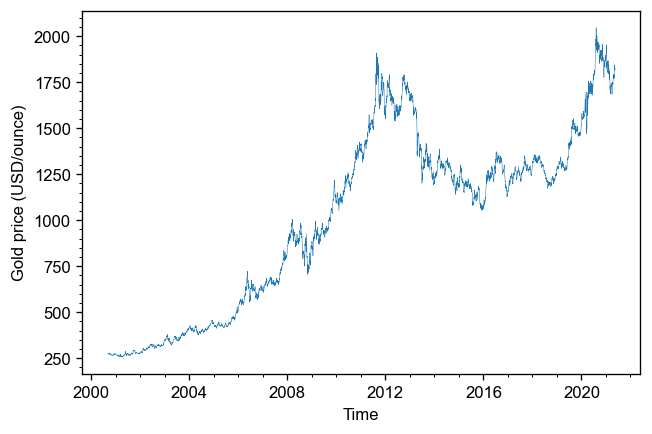

In [5]:
fig, ax=plt.subplots(1, 1)
ax.plot(gold[['open']], linewidth=0.3)
ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.set_xlabel('Time')
ax.set_ylabel('Gold price (USD/ounce)')
plt.show()

Now we analyze the characteristic properties of the gold price time series data. Is the price of gold random walk and totally non-predictable? We will analyze the trend, periodicity (seasonality), and autocorrelation of the data set, and test a way to make the data set stationary. 

In [6]:
#####################################################
# Test whether gold price time series is random walk
#####################################################
adfuller_result=adfuller(gold['open'].diff().dropna())
pd.DataFrame({' ': ['Value'], 'ADF Statistic:': ['{:.3f}'.format(adfuller_result[0])],
             'p-value:': ['{:.9f}'.format(adfuller_result[1])],
              'Critical Values 1%:': ['{:.3f}'.format(list(adfuller_result[4].values())[0])],
              'Critical Values 5%:': ['{:.3f}'.format(list(adfuller_result[4].values())[1])],
              'Critical Values 10%:': ['{:.3f}'.format(list(adfuller_result[4].values())[2])]
             }).set_index(' ').T

,Value
ADF Statistic:,-18.450
p-value:,0.000000000
Critical Values 1%:,-3.432
Critical Values 5%:,-2.862
Critical Values 10%:,-2.567


With an extremely small p-value from an Augmented Dickey-Fuller test on the first order difference of the gold price time series, we can reject the null hypothesis of random walk, and conclude that the time series is not a random walk. It is possible to predict the gold price!

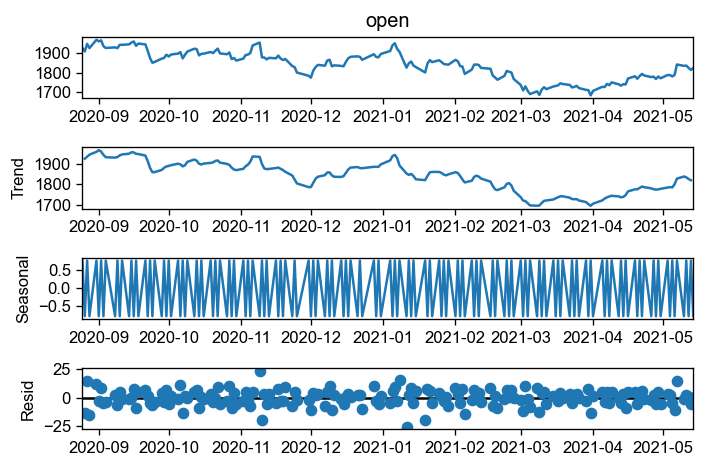

In [7]:
#####################################################################
# Decompose the gold price time series for the most recent half year
#####################################################################
seasonal_decompose(gold['open'].iloc[-180:], model='linear', period=2).plot()
plt.show()

It seems that the gold price has a seasonal component. It may due to a mean reversion: when the price gets higher, people want to sell, causing the price go lower, and then people want to buy, causing the price higher, again and again. 

It is possible to use the mean reversion to make the model profitable (to make prediction by the behavior of gold price itself), but I won't stop at that stage. This project is focusing on exogenous variables on gold prices and make a regression as precise as possible. The model will be able to predict the future gold prices in a considerable time windows (several days to a week).

In [8]:
#########################################################
# Use kpss to tell if apple stock return is stationary
#########################################################
pd.DataFrame({' ': ['p-value'], 
             '1 order of difference': [kpss(gold['open'].diff().dropna())[1]]}).set_index(' ').T

,p-value
1 order of difference,0.1


It turns out the gold return is stationary.

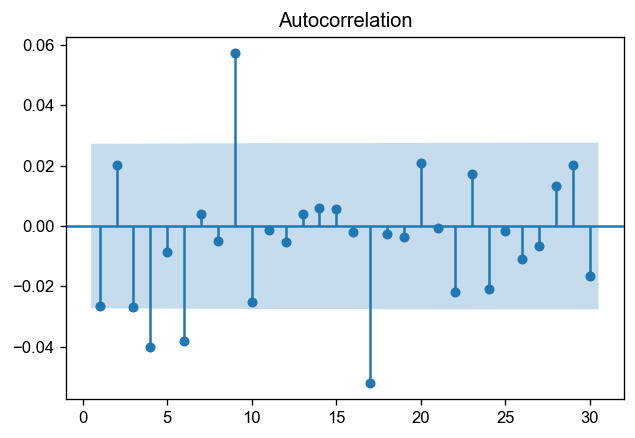

In [9]:
###################################################################################################################
# Autocorrelation investigation for gold price time series (95% confidence interval)
###################################################################################################################
_=plot_acf(gold['open'].diff().dropna(), lags=30, zero=False, alpha=0.05)
plt.show()

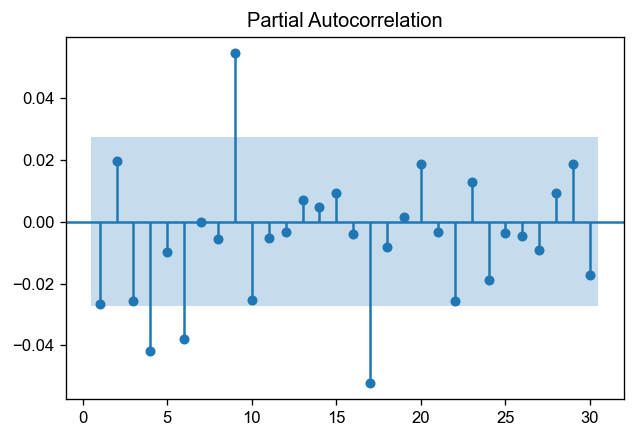

In [10]:
_=plot_pacf(gold['open'].diff().dropna(), lags=30, zero=False, alpha=0.05)
plt.show()

The first order difference (gold price return) makes the time series stationary, that makes $d$=1. However, it is not conclusive that which AR or MA model can fit the time series from the ACF and PACF plot. I am going to use hyperparameter tunning to find out.

## 2. Baseline Model: No Exogenous Variables

Next I am going to use an Autoregressive Integrated Moving Averages (ARIMA) model to fit and predict the gold prices. ARIMA is well-known for forecasting stocks and financial market fluctuations, and data scientists and researchers have been utilizing ARIMA model to predict the price of gold [1,6]. Without helps of exogenous variables, I will find out how good our prediction will be.

In my other projects, I found that if I predict gold or stock prices once a week, the prediction results are pretty good. However, making predictions once a week is not aggresive enough to make the model profitable. In this project, I am going to try a pattern of predicting twice per week. 

Note that for the time series machine learning practices, I have to pay attention that the model can never see any "future" data. In other words, "future" data cannot leak to the model. That is the key for the precision of the model.

Another thing is, if I consider using the whole data set, the early gold price is not in the same scale because of inflation and among other reasons. Machine learning models might misunderstanding the relatively cheap gold prices in old years. Therefore I only consider using the gold prices after 2018.

In [11]:
#################################
# Take a look at where data ends
#################################
gold[['open']].tail()

,open
Date,
2021-05-10,1835.599976
2021-05-11,1837.199951
2021-05-12,1825.199951
2021-05-13,1814.699951
2021-05-14,1824.500000


In [12]:
#################################################
# Fill missing values for weekends and holidays
#################################################
Y=gold[['open']].loc[pd.to_datetime("2018", format='%Y'):]
Y=Y.resample('D').ffill()
##############################################
# Train test split:
# Train 2018 to 2020
# Test 2020 to present
##############################################
y_train=Y.loc[Y.index<pd.to_datetime("2020", format='%Y')]
y_test=Y.loc[Y.index>=pd.to_datetime("2020", format='%Y')]

I use root mean squared error (RMSE) and precision for price rising as metrics for optimization. I want the predicted price number to be close to the real number, also more importantly I want the call about the price rising to be right. The unit of RMSE is also dollar ($). This is going to be my baseline model.   

## 3. Exogenous Variables

## 4. Conclusion

### References
[1] Aihui Ong, Is Gold a Good Investment? Gold Price Prediction Using Machine Learning Techniques. https://www.springboard.com/blog/gold-price-prediction-using-machine-learning, 2020.

[2] Bhanu Yerra, Predicting Tomorrows Gold Price. Do We Have a Market Advantage? https://mlbhanuyerra.github.io/2019-10-12-Predicting-Tomorrows-Gold-Price/, 2019.

[3] ur Sami, I., and Khurum Nazir Junejo. Predicting Future Gold Rates using Machine Learning Approach. International Journal of Advanced Computer Science and Applications 8, no. 12: 92-99, 2017.

[4] Potoski, Megan. Predicting gold prices. CS229, Autumn, 2013.

[5] Ishan Shah, and Rekhit Pachanekar, Gold Price Prediction Using Machine Learning In Python. https://blog.quantinsti.com/gold-price-prediction-using-machine-learning-python/, 2020  

[6] Bingol, Sakir, Safaa Sadik, Raland Matenggo, Hatim Badr Mouhcine, Jihad Albaf, Salma Chaabene, and Aaron Auta. Gold price prediction in times of 4inancial and geopolitical uncertainty: A machine learning approach. 2020.

[7] Zhu, Han-chao, and Wang, Dong. Predict the price of gold Based on Machine Learning Techniques. DEStech Transactions on Computer Science and Engineering mmsta, 2017.

[8] https://finance.yahoo.com

[9] Box, George EP, Gwilym M. Jenkins, Gregory C. Reinsel, and Greta M. Ljung. Time series analysis: forecasting and control. John Wiley & Sons, 2015.

[10] Ariyo, Adebiyi A., Adewumi O. Adewumi, and Charles K. Ayo. "Stock price prediction using the ARIMA model." In 2014 UKSim-AMSS 16th International Conference on Computer Modelling and Simulation, pp. 106-112. IEEE, 2014.

[11] https://medium.datadriveninvestor.com/time-series-prediction-using-sarimax-a6604f258c56

